# Interpreting transformer ERNIE TextClassification Models With Integrated Gradients

Interpretations of the predictions are generated and visualized using LIME algorithm, specifically the `LIMENLPInterpreter` class.

In [2]:
import paddle
import numpy as np
import interpretdl as it

from interpretdl.data_processor.visualizer import VisualizationTextRecord, visualize_text

If you have't done so, please first download the word dictionary that maps each word to an id.

## ERNIE([Enhanced Representation through Knowledge Integration](https://arxiv.org/pdf/1904.09223))

### 加载数据集
以公开中文情感分析数据集ChnSenticorp为例。PaddleNLP已经内置该数据集，一键即可加载。

In [3]:
import paddlenlp as ppnlp
from paddlenlp.datasets import load_dataset

train_ds, dev_ds, test_ds = load_dataset(
    "chnsenticorp", splits=["train", "dev", "test"])

print(train_ds.label_list)

for data in train_ds.data[:5]:
    print(data)

['0', '1']
{'text': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1, 'qid': ''}
{'text': '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错', 'label': 1, 'qid': ''}
{'text': '房间太小。其他的都一般。。。。。。。。。', 'label': 0, 'qid': ''}
{'text': '1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸，一摸一个印. 4.硬盘分区不好办.', 'label': 0, 'qid': ''}
{'text': '今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量商量,单独出个第6卷,让我们的孩子不会有所遗憾。', 'label': 1, 'qid': ''}


每条数据包含一句评论和对应的标签，0或1。0代表负向评论，1代表正向评论。

之后，还需要对输入句子进行数据处理，如切词，映射词表id等。

## PaddleNLP一键加载预训练模型

情感分析本质是一个文本分类任务，PaddleNLP对于各种预训练模型已经内置了对于下游任务-文本分类的Fine-tune网络。以下教程ERNIE为例，介绍如何将预训练模型Fine-tune完成文本分类任务。

`paddlenlp.transformers.ErnieModel()`一行代码即可加载预训练模型ERNIE。

`paddlenlp.transformers.ErnieForSequenceClassification()`一行代码即可加载预训练模型ERNIE用于文本分类任务的Fine-tune网络。其在ERNIE模型后拼接上一个全连接网络（Full Connected）进行分类。

`paddlenlp.transformers.ErnieForSequenceClassification.from_pretrained()` 只需指定想要使用的模型名称和文本分类的类别数即可完成网络定义。

`PaddleNLP`不仅支持ERNIE预训练模型，还支持`BERT`、`RoBERTa`、`Electra`等预训练模型，可跳转到文末了解更多。

In [4]:
# 设置想要使用模型的名称
MODEL_NAME = "ernie-1.0"

ernie_model = ppnlp.transformers.ErnieModel.from_pretrained(MODEL_NAME)

model = ppnlp.transformers.ErnieForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=len(train_ds.label_list))

[2021-07-09 16:26:45,355] [    INFO] - Already cached /root/.paddlenlp/models/ernie-1.0/ernie_v1_chn_base.pdparams
[2021-07-09 16:26:48,002] [    INFO] - Weights from pretrained model not used in ErnieModel: ['cls.predictions.layer_norm.weight', 'cls.predictions.decoder_bias', 'cls.predictions.transform.bias', 'cls.predictions.transform.weight', 'cls.predictions.layer_norm.bias']
[2021-07-09 16:26:48,279] [    INFO] - Already cached /root/.paddlenlp/models/ernie-1.0/ernie_v1_chn_base.pdparams
/opt/conda/envs/paddle2/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for classifier.weight. classifier.weight is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/paddle2/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1301: UserWarning: Skip loading for classifier.bias. classifier.bias is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str

### 调用`ppnlp.transformers.ErnieTokenizer`进行数据处理

预训练模型ERNIE对中文数据的处理是以字为单位。PaddleNLP对于各种预训练模型已经内置了相应的tokenizer。指定想要使用的模型名字即可加载对应的tokenizer。

tokenizer作用为将原始输入文本转化成模型model可以接受的输入数据形式。

![](https://bj.bcebos.com/paddlehub/paddlehub-img/ernie_network_1.png)

![](https://bj.bcebos.com/paddlehub/paddlehub-img/ernie_network_2.png)

In [5]:
tokenizer = ppnlp.transformers.ErnieTokenizer.from_pretrained(MODEL_NAME)

[2021-07-09 16:26:49,751] [    INFO] - Found /root/.paddlenlp/models/ernie-1.0/vocab.txt


In [6]:
import paddle

# 将原始输入文本切分token，
tokens = tokenizer._tokenize("请输入测试样例")
print("Tokens: {}".format(tokens))

# token映射为对应token id
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Tokens id: {}".format(tokens_ids))


# 拼接上预训练模型对应的特殊token ，如[CLS]、[SEP]
tokens_ids = tokenizer.build_inputs_with_special_tokens(tokens_ids)

# 转化成paddle框架数据格式
tokens_pd = paddle.to_tensor([tokens_ids])
print("Tokens : {}".format(tokens_pd))

# 此时即可输入ERNIE模型中得到相应输出
sequence_output, pooled_output = ernie_model(tokens_pd)
print("Token wise output: {}, Pooled output: {}".format(sequence_output.shape, pooled_output.shape))

Tokens: ['请', '输', '入', '测', '试', '样', '例']
Tokens id: [647, 789, 109, 558, 525, 314, 656]
Tokens : Tensor(shape=[1, 9], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[1  , 647, 789, 109, 558, 525, 314, 656, 2  ]])
Token wise output: [1, 9, 768], Pooled output: [1, 768]


/opt/conda/envs/paddle2/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


从以上代码可以看出，ERNIE模型输出有2个tensor。

- `sequence_output`是对应每个输入token的语义特征表示，shape为(1, num_tokens, hidden_size)。其一般用于序列标注、问答等任务。
- `pooled_output`是对应整个句子的语义特征表示，shape为(1, hidden_size)。其一般用于文本分类、信息检索等任务。

In [7]:
# 一行代码完成切分token，映射token ID以及拼接特殊token
encoded_text = tokenizer(text="请输入测试样例")
for key, value in encoded_text.items():
    print("{}:\n\t{}".format(key, value))

# 转化成paddle框架数据格式
input_ids = paddle.to_tensor([encoded_text['input_ids']])
print("input_ids : {}".format(input_ids))
segment_ids = paddle.to_tensor([encoded_text['token_type_ids']])
print("token_type_ids : {}".format(segment_ids))

# 此时即可输入ERNIE模型中得到相应输出
sequence_output, pooled_output = ernie_model(input_ids, segment_ids)
print("Token wise output: {}, Pooled output: {}".format(sequence_output.shape, pooled_output.shape))

input_ids:
	[1, 647, 789, 109, 558, 525, 314, 656, 2]
token_type_ids:
	[0, 0, 0, 0, 0, 0, 0, 0, 0]
input_ids : Tensor(shape=[1, 9], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[1  , 647, 789, 109, 558, 525, 314, 656, 2  ]])
token_type_ids : Tensor(shape=[1, 9], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [[0, 0, 0, 0, 0, 0, 0, 0, 0]])
Token wise output: [1, 9, 768], Pooled output: [1, 768]


由以上代码可以见，tokenizer提供了一种非常便利的方式生成模型所需的数据格式。

以上，

- `input_ids`: 表示输入文本的token ID。
- `segment_ids`: 表示对应的token属于输入的第一个句子还是第二个句子。（Transformer类预训练模型支持单句以及句对输入。）详细参见左侧utils.py文件中convert_example()函数解释。
- `seq_len`： 表示输入句子的token个数。
- `input_mask`：表示对应的token是否一个padding token。由于一个batch中的输入句子长度不同，所以需要将不同长度的句子padding到统一固定长度。1表示真实输入，0表示对应token为padding token。
- `position_ids`: 表示对应token在整个输入序列中的位置。

### 数据读入

In [8]:
from functools import partial
from paddlenlp.data import Stack, Tuple, Pad
from assets.utils import convert_example, create_dataloader

# 模型运行批处理大小
batch_size = 32
max_seq_length = 128

trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # segment
    Stack(dtype="int64")  # label
): [data for data in fn(samples)]
    
train_data_loader = create_dataloader(
    train_ds,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

dev_data_loader = create_dataloader(
    dev_ds,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

## Fine-Tune
适用于ERNIE/BERT这类Transformer模型的学习率为warmup的动态学习率。

In [9]:
from paddlenlp.transformers import LinearDecayWithWarmup

# 训练过程中的最大学习率
learning_rate = 5e-5 
# 训练轮次
epochs = 1 #3
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01

num_training_steps = len(train_data_loader) * epochs
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()
metric = paddle.metric.Accuracy()

### 模型训练与评估
模型训练的过程通常有以下步骤：

1. 从dataloader中取出一个batch data
2. 将batch data喂给model，做前向计算
3. 将前向计算结果传给损失函数，计算loss。将前向计算结果传给评价方法，计算评价指标。
4. loss反向回传，更新梯度。重复以上步骤。
5. 每训练一个epoch时，程序将会评估一次，评估当前模型训练的效果。

In [10]:
!mkdir -p assets/checkpoint

In [11]:
import paddle.nn.functional as F
from assets.utils import evaluate

global_step = 0
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        if global_step % 10 == 0 :
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
    evaluate(model, criterion, metric, dev_data_loader)

model.save_pretrained('assets/checkpoint')
tokenizer.save_pretrained('assets/checkpoint')

### 模型预测
训练保存好的训练，即可用于预测。如以下示例代码自定义预测数据，调`用`predict()`函数即可一键预测。

In [12]:
# 模型加载
state_dict = paddle.load("assets/checkpoint/model_state.pdparams")
model.set_dict(state_dict)

In [13]:
from assets.utils import predict

data = [
    {"text":'这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般'},
    {"text":'怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片'},
    {"text":'作为老的四星酒店，房间依然很整洁，相当不错。机场接机服务很好，可以在车上办理入住手续，节省时间。'},
]

label_map = {0: 'negative', 1: 'positive'}

results = predict(
    model, data, tokenizer, label_map, batch_size=batch_size)

for idx, text in enumerate(data):
    print('Data: {} \t Lable: {}'.format(text, results[idx]))

Data: {'text': '这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般'} 	 Lable: negative
Data: {'text': '怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片'} 	 Lable: negative
Data: {'text': '作为老的四星酒店，房间依然很整洁，相当不错。机场接机服务很好，可以在车上办理入住手续，节省时间。'} 	 Lable: positive


## Interpreting transformer ERNIE TextClassification Models

Initialize the `IntGradNLPInterpreter`. 

In [14]:
lime = it.LIMENLPInterpreter(model)

Define the reviews that we want to analyze. 

In [15]:
def preprocess_fn(data):
    examples = []

    input_ids, segment_ids = convert_example(
        data,
        tokenizer,
        max_seq_length=128,
        is_test=True)
    examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)
    
    input_ids, segment_ids = batchify_fn(examples)
    return paddle.to_tensor(input_ids, stop_gradient=False), paddle.to_tensor(segment_ids, stop_gradient=False)    

Define a preprocessing function that processes a list of raw strings into model inputs.

In the cell below, we `interpret` reviews and grab weights for each token.

Since the output gradients are not grouped by reviews due to the LoDTensor inputs, we use the LoD information to group them into a list of lists.

In [16]:
true_labels = [0, 0, 1]
recs = []

for i, review in enumerate(data):
    pred_class, pred_prob, lime_weights = lime.interpret(
        review,
        preprocess_fn,
        num_samples=1000,
        batch_size=32,
        unk_id=tokenizer.convert_tokens_to_ids('[UNK]'),
        pad_id=tokenizer.convert_tokens_to_ids('[PAD]'),
        return_pred=True)

    words = " ".join(tokenizer._tokenize(review['text'])).split(' ')
    interp_class = list(lime_weights.keys())[0]
    weights = lime_weights[interp_class][1 : -1]
    word_importances = [t[1] for t in lime_weights[interp_class][1 : -1]]
    word_importances = np.array(word_importances) / np.linalg.norm(
        word_importances)
    
    true_label = true_labels[i]
    
    if interp_class == 0:
        word_importances = -word_importances
        
    rec = VisualizationTextRecord(
        words, 
        word_importances, 
        true_label,                   
        pred_class[0], 
        pred_prob[0],
        interp_class
    )
    
    recs.append(rec)

visualize_text(recs)

The above cell's output is similar to the following:

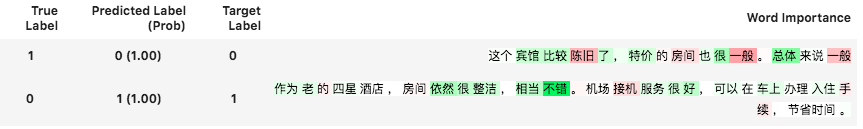

In [17]:
from IPython.display import Image
Image(filename='assets/lime_nlp_viz.png')